This notebook tests several engineered features.

**Key takeaway:**

Some of the newly added features appear important, including months_to_card_expiration, loan_to_debt_ratio, repayment_*_to_debt.  Step 3c will test removing less important ones. 

In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import xgboost as xgb

from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_auc_score, 
    roc_curve, 
    precision_recall_curve, 
    average_precision_score, 
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


In [2]:
# Function to create target variable
def create_target(df):

    # Create target variable
    df['default'] = (df.amount_outstanding_21d > 0).astype(int)

    return df

In [3]:
def add_features(df):

     # Loan_to_debt_ratio
    df['loan_to_debt_ratio'] = df['loan_amount'] / (df['existing_klarna_debt'] + df['loan_amount'])

    # New_exposure_7d_to_debt
    df['new_exposure_7d_to_debt'] = df['new_exposure_7d'] / (df['existing_klarna_debt'] + df['loan_amount'])

    # New_exposure_14d_to_debt
    df['new_exposure_14d_to_debt'] = df['new_exposure_14d'] / (df['existing_klarna_debt'] + df['loan_amount'])


    # Repayment to total debt
    df['repayment_1y_to_debt'] = (df['amount_repaid_1y'] / (df['existing_klarna_debt'] + df['loan_amount']))
    df['repayment_6m_to_debt'] = (df['amount_repaid_6m'] / (df['existing_klarna_debt'] + df['loan_amount']))
    df['repayment_3m_to_debt'] = (df['amount_repaid_3m'] / (df['existing_klarna_debt'] + df['loan_amount']))
    df['repayment_1m_to_debt'] = (df['amount_repaid_1m'] / (df['existing_klarna_debt'] + df['loan_amount']))
    df['repayment_14d_to_debt'] = (df['amount_repaid_14d'] / (df['existing_klarna_debt'] + df['loan_amount']))

    

    # Repayment consistency
    df['repayment_consistency'] = df[['amount_repaid_14d', 'amount_repaid_1m', 'amount_repaid_3m', 'amount_repaid_6m', 'amount_repaid_1y']].std(axis=1)


    # Repayment acceleration
    #df['repayment_acceleration'] = df['amount_repaid_14d'] - df['amount_repaid_1y'] 
    
    # drop amount_repaid_1y to avoid multicollinearity
    #df = df.drop(columns=['amount_repaid_1y'])
    

    # Repayment_rate variations
    epsilon = 1e-5  # Small constant

    # Repayment to new exposure 14d
    df['repayment_rate_to_new_14d'] = (df['amount_repaid_14d'] / (df['new_exposure_14d'] + epsilon)).astype(float)

    # Repayment to number of active loans
    df['repayment_rate_to_num'] = (df['amount_repaid_14d'] / (df['num_active_loans'] + epsilon)).astype(float)

    

    # Ratio of confirmed payments to active loans
    df['num_conf_payments_6m_to_num_loans'] = df['num_confirmed_payments_6m'] / (df['num_active_loans'] + epsilon)

    # Ratio of failed payments to active loans
    df['num_failed_payments_6m_to_num_loans'] = df['num_failed_payments_6m'] / (df['num_active_loans'] + epsilon)

     # Create number ratios
    df['num_failed_to_conf_payments_6m'] = df['num_failed_payments_6m'] / (df['num_confirmed_payments_6m'] + epsilon)

    df['num_failed_to_conf_payments_3m'] = df['num_failed_payments_3m'] / (df['num_confirmed_payments_3m'] + epsilon)

    return df


In [4]:
def impute_missing_debt(df):
    # Create a missingness flag for existing_klarna_debt
    df['existing_debt_missing'] = df['existing_klarna_debt'].isnull().astype(int)

    # Replace missing values for existing_klarna_debt with 0
    df['existing_klarna_debt'] = df['existing_klarna_debt'].fillna(0)

    # Create a missingness flag for card expiry date
    df['card_expiry_missing'] = df['card_expiry_month'].isnull().astype(int)

    return df

In [5]:
# Function to create card expiration date
def calculate_months_to_card_expiration(df):

    """
    Calculate card_expiry_date and months_to_card_expiration between loan_issue_date and card_expiry_date.
    """
    
    # Ensure loan_issue_date is datetime
    df['loan_issue_date'] = pd.to_datetime(df['loan_issue_date'], errors='coerce')

    # Combine year and month for card expiration
    df['card_expiry_date'] = pd.to_datetime(
        df.apply(
            lambda row: f"{int(row['card_expiry_year'])}-{int(row['card_expiry_month']):02d}-01"
            if pd.notna(row['card_expiry_year']) and pd.notna(row['card_expiry_month'])
            else np.nan,
            axis=1
        ), 
        errors='coerce'
    )

    # Calculate the difference in months
    df['months_to_card_expiration'] = np.where(
        df['card_expiry_date'].notna() & df['loan_issue_date'].notna(),
        (df['card_expiry_date'].dt.year - df['loan_issue_date'].dt.year) * 12 +
        (df['card_expiry_date'].dt.month - df['loan_issue_date'].dt.month),
        np.nan
    )

     # Convert month_to_card_expiration to integer
    df['months_to_card_expiration'] = df['months_to_card_expiration'].fillna(-1).astype(int).replace(-1, np.nan)

    return df


In [6]:
def reduce_cardinality(df, n = 10):

    """ Reduce cardinality of merchant variables by grouping low frequency categories into 'Other' """

    # Merchant categories
    top_n_categories = df['merchant_category'].value_counts().nlargest(n).index

    # Merchant groups
    top_n_groups = df['merchant_group'].value_counts().nlargest(n).index

    # Reassign categories outside the top n and 'Unknown' to 'Other'
    df['merchant_category'] = df['merchant_category'].apply(
        lambda x: 'Other' if x not in top_n_categories or x == 'Unknown' else x
    )

    # Reassign groups outside the top n and 'Unknown' to 'Other'
    df['merchant_group'] = df['merchant_group'].apply(
        lambda x: 'Other' if x not in top_n_groups or x == 'Unknown' else x
    )

    return df

# Load and split data

In [7]:
# Load the data
df = pd.read_csv('data/mlcasestudy.csv')

In [8]:
# Splitting the data into train, validation and test sets
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [9]:
# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_full_train = df_full_train.reset_index(drop=True)


In [10]:
# Apply the processing functions to the data

# create target variable
df_train = create_target(df_train)
df_val = create_target(df_val)
df_test = create_target(df_test)
df_full_train = create_target(df_full_train)

# add features
df_train = add_features(df_train)
df_val = add_features(df_val)
df_test = add_features(df_test)
df_full_train = add_features(df_full_train)

# impute missing debt values and create flags
df_train = impute_missing_debt(df_train)
df_val = impute_missing_debt(df_val)
df_test = impute_missing_debt(df_test)
df_full_train = impute_missing_debt(df_full_train)


# add months to card expiration column
df_train = calculate_months_to_card_expiration(df_train)
df_val = calculate_months_to_card_expiration(df_val)
df_test = calculate_months_to_card_expiration(df_test)
df_full_train = calculate_months_to_card_expiration(df_full_train)

# reduce cardinality of merchant variables
df_train = reduce_cardinality(df_train, n=10)
df_val = reduce_cardinality(df_val, n=10)
df_test = reduce_cardinality(df_test, n=10)
df_full_train = reduce_cardinality(df_full_train, n=10)


Prepare feature list

In [11]:
# Define helper columns
helper_columns = ['amount_outstanding_14d', 'amount_outstanding_21d', 
                  'card_expiry_month', 'card_expiry_year','card_expiry_date', 'loan_id', 'loan_issue_date']

# Extract categorical and numerical columns
categorical_features_eda = df_train.select_dtypes(include='object').columns.difference(helper_columns).tolist()
numerical_features_eda = df_train.select_dtypes(exclude='object').columns.difference(helper_columns + ['default']).tolist()


# Print categorical features 
print("\nCategorical features to explore:\n")
print("\n".join(categorical_features_eda))

# Print numerical features 
print("\nNumerical features to explore:\n")
print("\n".join(numerical_features_eda))




Categorical features to explore:

merchant_category
merchant_group

Numerical features to explore:

amount_repaid_14d
amount_repaid_1m
amount_repaid_1y
amount_repaid_3m
amount_repaid_6m
card_expiry_missing
days_since_first_loan
existing_debt_missing
existing_klarna_debt
loan_amount
loan_to_debt_ratio
months_to_card_expiration
new_exposure_14d
new_exposure_14d_to_debt
new_exposure_7d
new_exposure_7d_to_debt
num_active_loans
num_conf_payments_6m_to_num_loans
num_confirmed_payments_3m
num_confirmed_payments_6m
num_failed_payments_1y
num_failed_payments_3m
num_failed_payments_6m
num_failed_payments_6m_to_num_loans
num_failed_to_conf_payments_3m
num_failed_to_conf_payments_6m
repayment_14d_to_debt
repayment_1m_to_debt
repayment_1y_to_debt
repayment_3m_to_debt
repayment_6m_to_debt
repayment_consistency
repayment_rate_to_new_14d
repayment_rate_to_num


Feature selection - identify highly correlated features and drop to avoid multicollinearity. 

In [12]:
# Compute the correlation matrix
corr_matrix = df_train[numerical_features_eda].corr()

# Select the upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))


In [13]:

# Set the correlation threshold
threshold = 0.95

# Find index of features with correlation greater than the threshold
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > threshold)]

print(f'There are {len(to_drop)} columns to remove:')
print(to_drop)

There are 1 columns to remove:
['repayment_consistency']


Finalize list of features

In [14]:
# Remove from the list of features as needed
numerical_features = [
    feature for feature in numerical_features_eda 
    if feature not in to_drop 
    #and feature not in helper_columns
]

# Remove from the list of features as needed
categorical_features = categorical_features_eda 


# Print numerical features as a vertical list
print("\nNumerical features to use in training:\n")
print("\n".join(numerical_features))

# Print categorical features as a vertical list
print("\nCategorical features to use in training:\n")
print("\n".join(categorical_features))




Numerical features to use in training:

amount_repaid_14d
amount_repaid_1m
amount_repaid_1y
amount_repaid_3m
amount_repaid_6m
card_expiry_missing
days_since_first_loan
existing_debt_missing
existing_klarna_debt
loan_amount
loan_to_debt_ratio
months_to_card_expiration
new_exposure_14d
new_exposure_14d_to_debt
new_exposure_7d
new_exposure_7d_to_debt
num_active_loans
num_conf_payments_6m_to_num_loans
num_confirmed_payments_3m
num_confirmed_payments_6m
num_failed_payments_1y
num_failed_payments_3m
num_failed_payments_6m
num_failed_payments_6m_to_num_loans
num_failed_to_conf_payments_3m
num_failed_to_conf_payments_6m
repayment_14d_to_debt
repayment_1m_to_debt
repayment_1y_to_debt
repayment_3m_to_debt
repayment_6m_to_debt
repayment_rate_to_new_14d
repayment_rate_to_num

Categorical features to use in training:

merchant_category
merchant_group


In [15]:

# Assert that 'default' is not in numerical_features
assert 'default' not in numerical_features, "'default' is still in numerical_features!"


In [16]:
# Get all columns in df_train
all_columns = set(df_train.columns)

# Combine numerical_features and categorical_features
selected_features = set(numerical_features + categorical_features)

# Find columns that are not in either list
not_in_training = all_columns - selected_features

# Print the result
print("\nColumns not included in training:\n")
print("\n".join(sorted(not_in_training)))




Columns not included in training:

amount_outstanding_14d
amount_outstanding_21d
card_expiry_date
card_expiry_month
card_expiry_year
default
loan_id
loan_issue_date
repayment_consistency


# Preprocessing pipeline

In [17]:
df_train.merchant_category.value_counts()

merchant_category
General Shoes & Clothing             22731
Youthful Shoes & Clothing            10513
Other                                 9404
Adult Shoes & Clothing                5492
Event - Broker & Agencies             3914
Travel - Accommodation & Resorts      3817
Diversified Jewelry & Accessories     3695
Concept Stores & Miscellaneous        2742
Sports Gear & Outdoor                 2613
Food & Beverage                       1193
Furniture                             1026
Name: count, dtype: int64

Define the steps to prepare data for training and evaluation

In [18]:
# Create transformations for each type of features

# Numerical features - no processing
numerical_transformer = 'passthrough'

# Categorical features - one-hot encoding ignoring unknown categories
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

In [19]:
# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)



In [20]:
# Define the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

Apply preprocessing

In [21]:
# Transform training data
X_train_transformed = preprocessing_pipeline.fit_transform(df_train[numerical_features + categorical_features])
y_train = df_train['default'].values

# Transform validation data
X_val_transformed = preprocessing_pipeline.transform(df_val[numerical_features + categorical_features])
y_val = df_val['default'].values

In [22]:
# Get feature names from the preprocessing pipeline
numerical_features_transformed = numerical_features 

categorical_features_transformed = preprocessing_pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .named_steps['onehot'] \
    .get_feature_names_out(categorical_features)

# Combine numerical and transformed categorical feature names
all_feature_names = list(numerical_features_transformed) + list(categorical_features_transformed)

In [23]:
all_feature_names

['amount_repaid_14d',
 'amount_repaid_1m',
 'amount_repaid_1y',
 'amount_repaid_3m',
 'amount_repaid_6m',
 'card_expiry_missing',
 'days_since_first_loan',
 'existing_debt_missing',
 'existing_klarna_debt',
 'loan_amount',
 'loan_to_debt_ratio',
 'months_to_card_expiration',
 'new_exposure_14d',
 'new_exposure_14d_to_debt',
 'new_exposure_7d',
 'new_exposure_7d_to_debt',
 'num_active_loans',
 'num_conf_payments_6m_to_num_loans',
 'num_confirmed_payments_3m',
 'num_confirmed_payments_6m',
 'num_failed_payments_1y',
 'num_failed_payments_3m',
 'num_failed_payments_6m',
 'num_failed_payments_6m_to_num_loans',
 'num_failed_to_conf_payments_3m',
 'num_failed_to_conf_payments_6m',
 'repayment_14d_to_debt',
 'repayment_1m_to_debt',
 'repayment_1y_to_debt',
 'repayment_3m_to_debt',
 'repayment_6m_to_debt',
 'repayment_rate_to_new_14d',
 'repayment_rate_to_num',
 'merchant_category_Concept Stores & Miscellaneous',
 'merchant_category_Diversified Jewelry & Accessories',
 'merchant_category_Event

# Train model

In [24]:
# Initialize a dictionary to store the best models and their scores
best_models = {}

Gradient Boosted Trees

In [25]:

### XGBoost Tuning ###
pipeline_xgb = Pipeline([
    ('model', xgb.XGBClassifier(objective='binary:logistic')) 
    #nthread=8 for 8 CPU threads, the default is to automatically use the optimal number of threads
   
])

param_grid_xgb = {
    
    'model__n_estimators': [100], # number of trees
    'model__eta': [0.01, 0.1, 0.2], # contribution of each tree
    'model__max_depth': [3, 6, 9], # max number of splits
    'model__min_child_weight': [3, 5, 7], # min amount of data in leaf node
    #'model__subsample': [0.6, 0.8, 1.0], # fraction of training data used to grow trees
    #'model__colsample_bytree': [0.6, 0.8, 1.0], # fraction of features sampled for each tree
    #'model__gamma': [0, 1, 5], # min loss reduction

}

grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, scoring='roc_auc', cv=4, verbose=1)
grid_search_xgb.fit(X_train_transformed, y_train)

# Store the best XGBoost model and its AUC score
best_models['XGBoost'] = {
    'model': grid_search_xgb.best_estimator_,
    'auc': grid_search_xgb.best_score_
}

print("Best XGBoost parameters:", grid_search_xgb.best_params_)
print("Best XGBoost AUC:", grid_search_xgb.best_score_)


Fitting 4 folds for each of 27 candidates, totalling 108 fits
Best XGBoost parameters: {'model__eta': 0.1, 'model__max_depth': 3, 'model__min_child_weight': 3, 'model__n_estimators': 100}
Best XGBoost AUC: 0.6802507550765053


# Train the best model on the full training data

### Final training data

In [26]:
# Transform full training data
X_full_train_transformed = preprocessing_pipeline.fit_transform(df_full_train[numerical_features + categorical_features])
y_full_train = df_full_train['default'].values

# Transform test data
X_test_transformed = preprocessing_pipeline.transform(df_test[numerical_features + categorical_features])
y_test = df_test['default'].values


In [27]:
# Fit the best model on the full training data
best_model = best_models['XGBoost']['model']
best_model.fit(X_full_train_transformed, y_full_train)

Pipeline(steps=[('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.1,
                               eval_metric=None, feature_types=None, gamma=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=3,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [28]:
y_pred = best_model.predict_proba(X_test_transformed)[:, 1]

In [29]:
# Final AUC score on test data
auc = roc_auc_score(y_test, y_pred)
print(f"Test AUC: {auc}")

Test AUC: 0.6886944889508665


In [30]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)

# Baseline precision line
baseline_class_proportion = y_test.mean()


Save curves to compare with other models

In [31]:


# Create a dictionary to store the metrics
roc_pr_data = {
    'roc': {'fpr': fpr.tolist(), 'tpr': tpr.tolist(), 'roc_auc': roc_auc},
    'pr': {'precision': precision.tolist(), 'recall': recall.tolist(), 'ap': ap}
}

# Save to JSON file
with open('model_spec_step3b_metrics.json', 'w') as f:
    json.dump(roc_pr_data, f)

print("Metrics saved to model_spec_3b_metrics.json")


Metrics saved to model_spec_3b_metrics.json


Load model from the previous step

In [32]:
with open('model_spec_step3a_metrics.json', 'r') as f:
    roc_pr_data_1 = json.load(f)

# Extract the data
fpr_1 = roc_pr_data_1['roc']['fpr']
tpr_1 = roc_pr_data_1['roc']['tpr']
roc_auc_1 = roc_pr_data_1['roc']['roc_auc']

precision_1 = roc_pr_data_1['pr']['precision']
recall_1 = roc_pr_data_1['pr']['recall']
ap_1 = roc_pr_data_1['pr']['ap']


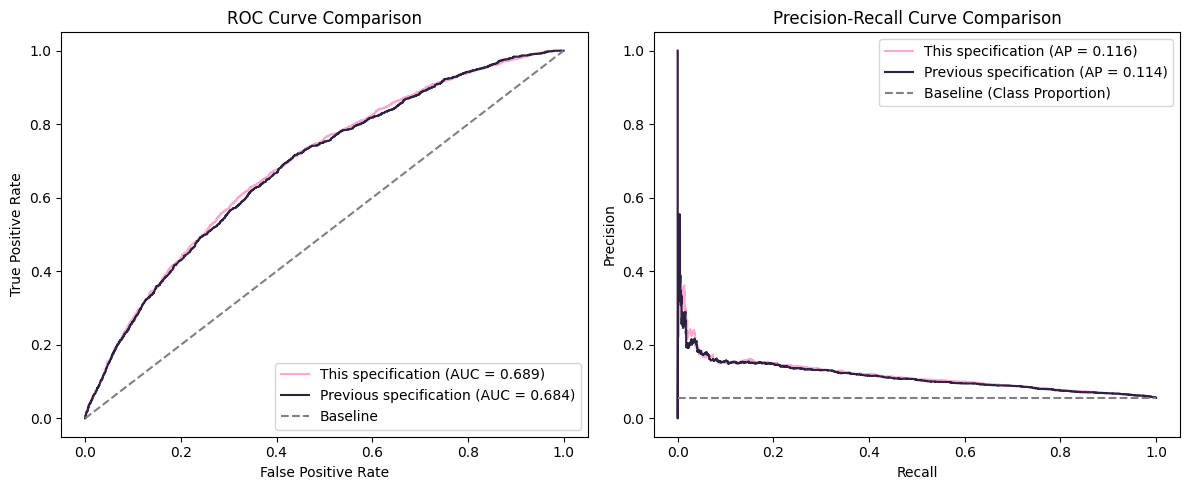

In [33]:
# Compare current model with the previous model
plt.figure(figsize=(12, 5))

# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'This specification (AUC = {roc_auc:.3f})', color = '#FFA8CD')  
plt.plot(fpr_1, tpr_1, label=f'Previous specification (AUC = {roc_auc_1:.3f})', color = '#2C2242')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Plot Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'This specification (AP = {ap:.3f})', color = '#FFA8CD')
plt.plot(recall_1, precision_1, label=f'Previous specification (AP = {ap_1:.3f})', color = '#2C2242')
plt.hlines(y_test.mean(), xmin=0, xmax=1, color='grey', linestyle='--', label='Baseline (Class Proportion)')
plt.title('Precision-Recall Curve Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Feature importance

In [34]:
model_object = best_model.named_steps['model']

In [35]:

# Create SHAP TreeExplainer for the tree-based model
explainer = shap.TreeExplainer(model_object)

# Calculate SHAP values
shap_values = explainer.shap_values(X_full_train_transformed)

# Wrap shap_values into an Explanation object
shap_values_with_names = shap.Explanation(
    values=shap_values,                   # SHAP values matrix
    base_values=explainer.expected_value, # Base values
    data=X_full_train_transformed,        # Transformed feature values
    feature_names=all_feature_names       # Feature names
)


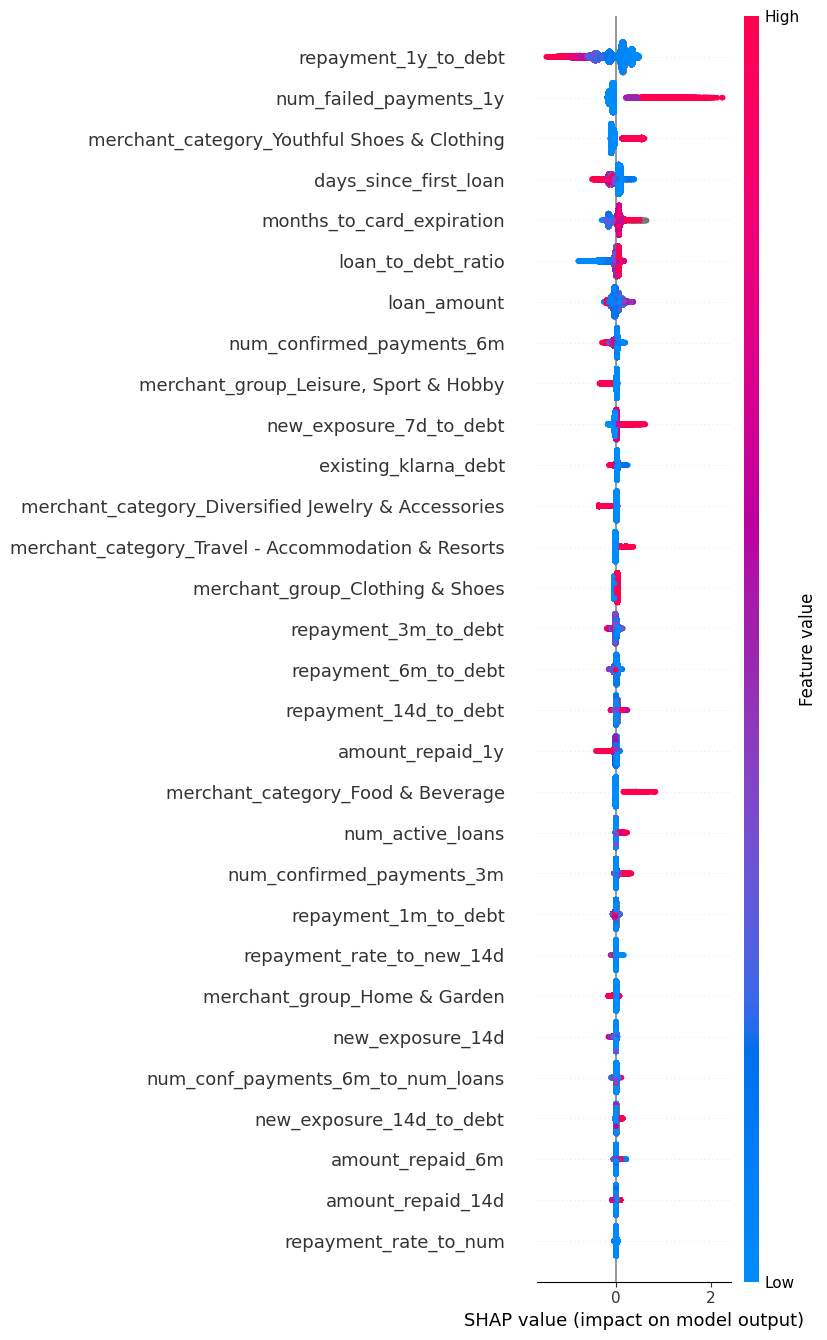

In [36]:
#  Density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output
shap.summary_plot(shap_values_with_names, X_full_train_transformed, max_display = 30)

Conclusion: sevaral of the newly added features appear important. Next step will test removing less important ones. 